<h2>Chord Embeddings</h2>
<br>
In this notebook we will try to create chord embeddings the same way we do at NLP with Word Embeddings.<br>


In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#python input/output and regex
import re
import os
from pathlib import Path

#chord info
import pychord as pc

#librosa
import librosa 

#signal processing libraries
from scipy.io import wavfile
from scipy import signal

#dimensionality reduction
from sklearn.manifold import TSNE

#embeddings
from gensim.models import Word2Vec

Create my <b>"Sentences"</b>
<hr>
1. Load chordlab files with annotations<br>

In [40]:
Band = 'The Beatles'
### get all chordlab files
Chordlab = {'The Beatles': {}}
for filename in Path('Big-Dataset/The Beatles').glob('**/chordlab/**/*.lab'):
    
    path, track = os.path.split(filename)
    path, album = os.path.split(path)
    track_no = re.search('([0-9].)_-_',track).group(1)
    
    if (album not in Chordlab[Band]): 
        Chordlab[Band][album] = {}
        
    Chordlab[Band][album][track_no] = pd.read_csv(filename, names=['Starts', 'Ends', 'Chord'], sep=' ', header=None)

2. Transform annotations to chord progressions - or else sentences.<br>

In [41]:
Chord_Progressions = []
for album in Chordlab[Band].keys():
    for track_no in Chordlab[Band][album].keys():
        progression = []
        for index, row in Chordlab[Band][album][track_no].iterrows():
            # filter out silences (N)
            if (row['Chord'] != 'N'):
                progression.append(row['Chord'])
        Chord_Progressions.append(progression)

<b>Vocabulary</b>

In [42]:
### Load all chords in a dictionary
Chords = []
for album in Chordlab['The Beatles'].keys():
    for track_no in Chordlab['The Beatles'][album].keys():
        for index, row in Chordlab['The Beatles'][album][track_no].iterrows():
            if row['Chord'] not in Chords: Chords.append(row['Chord'])
                
### How many chords do we have in our dataset?
vocab_size = len(Chords)
print ("Vocab Size: ",vocab_size)

Vocab Size:  407


<h2>Chord Embeddings</h2>
<br>
Let's build some Chord embeddings, just by looking at chord progressions as text, without looking at any notes or harmony beneath.<br>


In [73]:
# easy embeddings with gensim
model = Word2Vec(Chord_Progressions, size=100, window=5, min_count=1, negative=5, workers=4)

model.train(Chord_Progressions, total_examples=len(Chord_Progressions), epochs=2)

model.wv.most_similar(positive='F')

[('A:min', 0.9433127641677856),
 ('C', 0.9350109100341797),
 ('F:7', 0.8986030220985413),
 ('D:min', 0.8935830593109131),
 ('G:min', 0.8932269215583801),
 ('C:7', 0.8883724212646484),
 ('A:min7', 0.8853769302368164),
 ('C/5', 0.8850188255310059),
 ('E/b6', 0.8834120631217957),
 ('Bb', 0.8792223334312439)]

<b>Results: </b>As we can see, it responded quite well. All those good results, are chords that are seen before-after <b>F</b>
<br>
Now, let's plot the chords vectors with <b>TSNE for dimensionality reduction</b><br>

In [74]:
def tsne_plot(model, w2v):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word, val in model:
        tokens.append(w2v.wv[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(15,6)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()


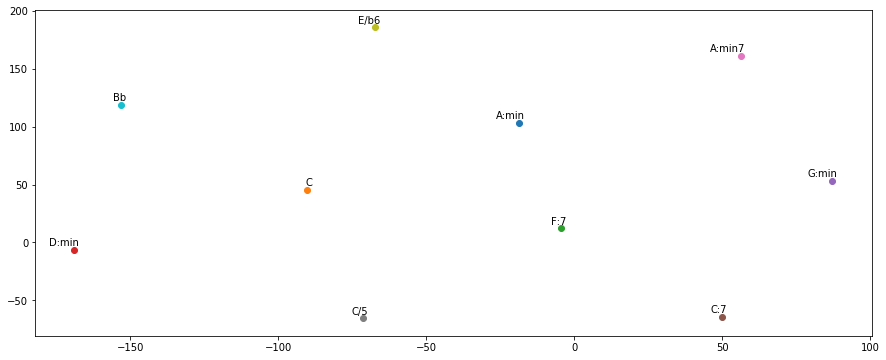

In [79]:
#plot
tsne_plot(model.wv.most_similar(positive='F'), model)